# Source contributions

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
import seaborn as sns; sns.set()
import pandas as pd
from datetime import date

%matplotlib notebook

###### Parameters:

In [5]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax-imin
jsize = jmax-jmin

# model result set:
results_folder1 = '/data/brogalla/run_storage/Mn-set4-202004/'
results_folder2 = '/data/brogalla/run_storage/Mn-set5-202008/'

colors = ['#ccb598', '#448d90', '#739f78', '#CC8741', '#cee7fd', '#b9c1c7']

In [6]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, \
         2017, 2018, 2019]

###### Load files:

In [7]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
mesh      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12-EXH006_y2015m01d05_gridT.nc')
lons      = np.array(mesh.variables['nav_lon'])
lats      = np.array(mesh.variables['nav_lat'])

e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t      = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t
volume_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), volume)

##### Functions:

In [8]:
def load_results(folder_ref, year):
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    dmn_riv = np.empty((12,isize,jsize))   ; dmn_sed = np.empty((12,isize,jsize)); 
    dmn_atm = np.empty((12,isize,jsize))   ; dmn_ice = np.empty((12,isize,jsize));
    dmn_sedice = np.empty((12,isize,jsize));
    dmn_red = np.empty((12,50,isize,jsize)); dmn_oxi = np.empty((12,50,isize,jsize))
    
    i=0
    for month in months:
        file        = 'ANHA12_EXH006_1m_'+str(year)+'0101_'+str(year)+'1231_comp_'+str(year)+month+'-'+str(year)+month+'.nc'
        ref_monthly = nc.Dataset(folder_ref+file)
        
        dmn_riv[i,:,:]    = np.array(ref_monthly.variables['dmnriv'])[0,:,:]
        dmn_sed[i,:,:]    = np.array(ref_monthly.variables['dmnsed'])[0,:,:]
        dmn_sedice[i,:,:] = np.array(ref_monthly.variables['dmnsedice'])[0,:,:]
        dmn_atm[i,:,:]    = np.array(ref_monthly.variables['dmnatm'])[0,:,:]
        dmn_ice[i,:,:]    = np.array(ref_monthly.variables['dmnice'])[0,:,:]
        dmn_red[i,:,:,:]  = np.array(ref_monthly.variables['dmnred'])[0,:,:,:]
        dmn_oxi[i,:,:,:]  = np.array(ref_monthly.variables['dmnoxi'])[0,:,:,:]
        i+=1
    
    tmask_surf    = np.empty(dmn_riv.shape)
    tmask_surf[:] = tmask[0,:,:]
    tmask_full    = np.empty(dmn_red.shape)
    tmask_full[:] = tmask
    
    # Mask points on land:
    dmn_mriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_riv); 
    dmn_msed    = np.ma.masked_where((tmask_surf < 0.1), dmn_sed)
    dmn_msedice = np.ma.masked_where((tmask_surf < 0.1), dmn_sedice)
    dmn_matm    = np.ma.masked_where((tmask_surf < 0.1), dmn_atm)
    dmn_mice    = np.ma.masked_where((tmask_surf < 0.1), dmn_ice)
    dmn_mred    = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_moxi    = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)

    return dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred , dmn_moxi

In [9]:
def calculate_contribution(results_folder, year, mask, output=False):
    # Calculate the contribution of the model components to Canada Basin specifically
    
    
    folder_year = 'ref-'+str(year)+'/'
    dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred, dmn_moxi = load_results(results_folder+\
                                                                                           folder_year, year)
    # moles per second
    riv    = np.ma.masked_where(mask==0, dmn_mriv)    * volume_masked[0,:,:] * 1e3
    sed    = np.ma.masked_where(mask==0, dmn_msed)    * volume_bottom * 1e3
    sedice = np.ma.masked_where(mask==0, dmn_msedice) * volume_masked[0,:,:] * 1e3
    atm    = np.ma.masked_where(mask==0, dmn_matm)    * volume_masked[0,:,:] * 1e3
    ice    = np.ma.masked_where(mask==0, dmn_mice)    * volume_masked[0,:,:] * 1e3
    
    # moles per meter squared per second
    rivm2    = np.ma.masked_where(mask==0, dmn_mriv)    * e3t_masked[0,:,:] * 1e3
    sedm2    = np.ma.masked_where(mask==0, dmn_msed)    * e3t_bottom * 1e3
    sedicem2 = np.ma.masked_where(mask==0, dmn_msedice) * e3t_masked[0,:,:] * 1e3
    atmm2    = np.ma.masked_where(mask==0, dmn_matm)    * e3t_masked[0,:,:] * 1e3
    icem2    = np.ma.masked_where(mask==0, dmn_mice)    * e3t_masked[0,:,:] * 1e3
    
    # Yearly contribution to domain: 
    atm_year    = np.ma.sum(atm[:,:,:], axis=(0,1,2))   *3600*24*365
    riv_year    = np.ma.sum(riv[:,:,:], axis=(0,1,2))   *3600*24*365
    sed_year    = np.ma.sum(sed[:,:,:], axis=(0,1,2))   *3600*24*365
    sedice_year = np.ma.sum(sedice[:,:,:], axis=(0,1,2))*3600*24*365
    ice_year    = np.ma.sum(ice[:,:,:], axis=(0,1,2))   *3600*24*365
    
    # Average yearly contribution over domain:
    atmm2_year    = np.ma.average(np.ma.sum(atmm2[:,:,:], axis=(0)))   *3600*24*365
    rivm2_year    = np.ma.average(np.ma.sum(rivm2[:,:,:], axis=(0)))   *3600*24*365
    sedm2_year    = np.ma.average(np.ma.sum(sedm2[:,:,:], axis=(0)))   *3600*24*365
    sedicem2_year = np.ma.average(np.ma.sum(sedicem2[:,:,:], axis=(0)))*3600*24*365
    icem2_year    = np.ma.average(np.ma.sum(icem2[:,:,:], axis=(0)))   *3600*24*365

    total_yearly_contribution = np.array([riv_year, sed_year, sedice_year, ice_year, atm_year])           # mol/yr
    ave_yearly_contribution   = np.array([rivm2_year, sedm2_year, sedicem2_year, icem2_year, atmm2_year]) # mol/m2/yr
    
    if output:
        print('-------------------------------------------------------------------')
       
        print('Yearly contribution of Mn to domain: [Mmol/yr, %]')
        print('River discharge              --- ', '{:.3}'.format(riv_year*1e-6), '---', \
                              '{:.3}'.format(riv_year*100/np.sum(total_yearly_contribution)))
        print('Sediment resuspension        --- ', '{:.3}'.format(sed_year*1e-6), '---', \
                              '{:.3}'.format(sed_year*100/np.sum(total_yearly_contribution)))
        print('Sediment released by sea ice --- ', '{:.3}'.format(sedice_year*1e-6), '---', \
                              '{:.3}'.format(sedice_year*100/np.sum(total_yearly_contribution)))
        print('Dust released by sea ice     --- ', '{:.3}'.format(ice_year*1e-6), '---', \
                              '{:.3}'.format(ice_year*100/np.sum(total_yearly_contribution)))
        print('Dust deposition              --- ', '{:.3}'.format(atm_year*1e-6), '---', \
                              '{:.3}'.format(atm_year*100/np.sum(total_yearly_contribution)))
        
        print('-------------------------------------------------------------------')
      
        print('Average contribution of Mn: [micromoles/m2/yr, %]')
        print('River discharge              --- ', '{:.3}'.format(rivm2_year*1e6), '---', \
                              '{:.3}'.format(rivm2_year*100/np.sum(ave_yearly_contribution)))
        print('Sediment resuspension        --- ', '{:.3}'.format(sedm2_year*1e6), '---', \
                              '{:.3}'.format(sedm2_year*100/np.sum(ave_yearly_contribution)))
        print('Sediment released by sea ice --- ', '{:.3}'.format(sedicem2_year*1e6), '---', \
                              '{:.3}'.format(sedicem2_year*100/np.sum(ave_yearly_contribution)))
        print('Dust released by sea ice     --- ', '{:.3}'.format(icem2_year*1e6), '---', \
                              '{:.3}'.format(icem2_year*100/np.sum(ave_yearly_contribution)))
        print('Dust deposition              --- ', '{:.3}'.format(atmm2_year*1e6), '---', \
                              '{:.3}'.format(atmm2_year*100/np.sum(ave_yearly_contribution)))

        print('-------------------------------------------------------------------')
    
    return total_yearly_contribution, ave_yearly_contribution

### Calculations:

Find grid cell volume and thickness at ocean floor:

In [10]:
tmask_bot = np.copy(tmask)
tmask_bot[0,:,:] = 1
e3t_mask = np.ma.masked_where((tmask_bot[:,:,:] < 0.1), e3t[:,:,:])

# find bottom grid cell index:
ind = np.array(np.ma.notmasked_edges(e3t_mask[:,:,:], axis=0))

# array of shape (isize, jsize) containing bottom grid cell index
index_bottom = np.ma.masked_where((tmask[0,:,:] < 0.1), ind[1][0][:].reshape(isize,jsize))
# index_bottom = np.ma.argmax(e3t_masked[:,:,:], axis=0)

In [11]:
e3t_bot = np.zeros((isize,jsize))
vol_bot = np.zeros((isize,jsize))

for i in range(0, isize):
    for j in range(0,jsize):
        k = index_bottom[i,j]
        try:
            e3t_bot[i,j] = e3t[k,i,j]
            vol_bot[i,j] = volume[k,i,j]
        except:
            e3t_bot[i,j] = np.nan
            vol_bot[i,j] = np.nan
        
e3t_bottom    = np.ma.masked_where((tmask[0,:,:] < 0.1), np.ma.masked_where(np.isnan(e3t_bot), e3t_bot))
volume_bottom = np.ma.masked_where((tmask[0,:,:] < 0.1), np.ma.masked_where(np.isnan(vol_bot), vol_bot))

Create masks for specific subregions:
- Canada Basin
- CAA
- Full domain
- Western CAA (separated by Barrow Sill)
- Eastern CAA (separated by Barrow Sill)

In [12]:
# Find indices to separate out Canada Basin:

x_ind = np.arange(1620, 2100, 1)
y_ind = (-7/8)*x_ind + 1517 + 700

CB_indx = []
CB_indy = []

for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2180,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)

In [13]:
# Separate Canada Basin and the CAA:
mask_ini_CB  = np.zeros((isize,jsize))
mask_ini_CAA = np.ones((isize,jsize))

for i, j in zip(CB_indx, CB_indy):
    mask_ini_CB[int(i-imin),int(j-jmin)]  = 1
    mask_ini_CAA[int(i-imin),int(j-jmin)] = 0
    
mask_ini_CB[150:-1 ,-8:-1] = 1
mask_ini_CAA[150:-1,-8:-1] = 0


In [14]:
mask_ini_wCAA = np.zeros((isize,jsize))
mask_ini_eCAA = np.zeros((isize,jsize))

# Separate the western and eastern CAA:
mask_ini_wCAA = np.where(lons[imin:imax,jmin:jmax] < -100, 1, 0)
mask_ini_eCAA = np.where(lons[imin:imax,jmin:jmax] > -100, 1, 0)

for i, j in zip(CB_indx, CB_indy):
    mask_ini_wCAA[int(i-imin),int(j-jmin)] = 0
    mask_ini_eCAA[int(i-imin),int(j-jmin)] = 0
    
mask_ini_wCAA[150:-1,-8:-1] = 0
mask_ini_eCAA[150:-1,-8:-1] = 0

In [15]:
mask_CB_yr    = np.tile(mask_ini_CB  , (12,1,1))
mask_CAA_yr   = np.tile(mask_ini_CAA , (12,1,1))
mask_full_yr  = np.ones((12, isize, jsize))
mask_wCAA_yr  = np.tile(mask_ini_wCAA, (12,1,1))
mask_eCAA_yr  = np.tile(mask_ini_eCAA, (12,1,1))

In [16]:
mask_CB_depth = np.tile(mask_CB_yr  , (50,1,1,1))
mask_CB_depth = mask_CB_depth.reshape(12,50,700,640)

##### Full region:

In [101]:
totals_exp1   = np.empty((len(years),5)); totals_exp2 = np.empty((len(years),5));
averages_exp1 = np.empty((len(years),5)); averages_exp2 = np.empty((len(years),5));

totals_exp1[:]   = np.NaN; totals_exp2[:]   = np.NaN;
averages_exp1[:] = np.NaN; averages_exp2[:] = np.NaN;

i=0
for year in years:
    total_exp1_year, ave_exp1_year = calculate_contribution(results_folder1, year, mask_full_yr, output=False)
    total_exp2_year, ave_exp2_year = calculate_contribution(results_folder2, year, mask_full_yr, output=False)
    
    totals_exp1[i,:]   = total_exp1_year 
    totals_exp2[i,:]   = total_exp2_year 
    averages_exp1[i,:] = ave_exp1_year 
    averages_exp2[i,:] = ave_exp2_year 
    
    i+=1

###### Canada Basin:

In [102]:
CB_totals_exp1   = np.empty((len(years),5)); CB_totals_exp2 = np.empty((len(years),5));
CB_averages_exp1 = np.empty((len(years),5)); CB_averages_exp2 = np.empty((len(years),5));

CB_totals_exp1[:]   = np.NaN; CB_totals_exp2[:]   = np.NaN;
CB_averages_exp1[:] = np.NaN; CB_averages_exp2[:] = np.NaN;

i=0
for year in years:
    total_CB_exp1_year, ave_CB_exp1_year = calculate_contribution(results_folder1, year, mask_CB_yr, output=False)
    total_CB_exp2_year, ave_CB_exp2_year = calculate_contribution(results_folder2, year, mask_CB_yr, output=False)
    
    CB_totals_exp1[i,:]   = total_CB_exp1_year 
    CB_totals_exp2[i,:]   = total_CB_exp2_year 
    CB_averages_exp1[i,:] = ave_CB_exp1_year 
    CB_averages_exp2[i,:] = ave_CB_exp2_year 
    
    i+=1

###### CAA:

In [103]:
CAA_totals_exp1   = np.empty((len(years),5)); CAA_totals_exp2 = np.empty((len(years),5));
CAA_averages_exp1 = np.empty((len(years),5)); CAA_averages_exp2 = np.empty((len(years),5));

CAA_totals_exp1[:]   = np.NaN; CAA_totals_exp2[:]   = np.NaN;
CAA_averages_exp1[:] = np.NaN; CAA_averages_exp2[:] = np.NaN;

i=0
for year in years:
    total_CAA_exp1_year, ave_CAA_exp1_year = calculate_contribution(results_folder1, year, mask_CAA_yr, output=False)
    total_CAA_exp2_year, ave_CAA_exp2_year = calculate_contribution(results_folder2, year, mask_CAA_yr, output=False)
    
    CAA_totals_exp1[i,:]   = total_CAA_exp1_year 
    CAA_totals_exp2[i,:]   = total_CAA_exp2_year 
    CAA_averages_exp1[i,:] = ave_CAA_exp1_year 
    CAA_averages_exp2[i,:] = ave_CAA_exp2_year 
    
    i+=1

###### Western vs. Eastern CAA

In [104]:
wCAA_totals_exp1   = np.empty((len(years),5)); wCAA_totals_exp2 = np.empty((len(years),5));
wCAA_averages_exp1 = np.empty((len(years),5)); wCAA_averages_exp2 = np.empty((len(years),5));

wCAA_totals_exp1[:]   = np.NaN; wCAA_totals_exp2[:]   = np.NaN;
wCAA_averages_exp1[:] = np.NaN; wCAA_averages_exp2[:] = np.NaN;

i=0
for year in years:
    total_wCAA_exp1_year, ave_wCAA_exp1_year = calculate_contribution(results_folder1, year, mask_wCAA_yr, output=False)
    total_wCAA_exp2_year, ave_wCAA_exp2_year = calculate_contribution(results_folder2, year, mask_wCAA_yr, output=False)
    
    wCAA_totals_exp1[i,:]   = total_wCAA_exp1_year 
    wCAA_totals_exp2[i,:]   = total_wCAA_exp2_year 
    wCAA_averages_exp1[i,:] = ave_wCAA_exp1_year 
    wCAA_averages_exp2[i,:] = ave_wCAA_exp2_year 
    
    i+=1

In [105]:
eCAA_totals_exp1   = np.empty((len(years),5)); eCAA_totals_exp2 = np.empty((len(years),5));
eCAA_averages_exp1 = np.empty((len(years),5)); eCAA_averages_exp2 = np.empty((len(years),5));

eCAA_totals_exp1[:]   = np.NaN; eCAA_totals_exp2[:]   = np.NaN;
eCAA_averages_exp1[:] = np.NaN; eCAA_averages_exp2[:] = np.NaN;

i=0
for year in years:
    total_eCAA_exp1_year, ave_eCAA_exp1_year = calculate_contribution(results_folder1, year, mask_eCAA_yr, output=False)
    total_eCAA_exp2_year, ave_eCAA_exp2_year = calculate_contribution(results_folder2, year, mask_eCAA_yr, output=False)
    
    eCAA_totals_exp1[i,:]   = total_eCAA_exp1_year 
    eCAA_totals_exp2[i,:]   = total_eCAA_exp2_year 
    eCAA_averages_exp1[i,:] = ave_eCAA_exp1_year 
    eCAA_averages_exp2[i,:] = ave_eCAA_exp2_year 
    
    i+=1

### Pickle the results from these calculations:

In [106]:
pickle.dump((totals_exp1, CB_totals_exp1, CAA_totals_exp1, wCAA_totals_exp1, eCAA_totals_exp1),\
            open('calculations/exp1-total_component_contributions-20201018.pickle','wb'))

In [107]:
pickle.dump((totals_exp2, CB_totals_exp2, CAA_totals_exp2, wCAA_totals_exp2, eCAA_totals_exp2),\
            open('calculations/exp2-total_component_contributions-20201018.pickle','wb'))

In [108]:
pickle.dump((averages_exp1, CB_averages_exp1, CAA_averages_exp1, wCAA_averages_exp1, eCAA_averages_exp1),\
            open('calculations/exp1-averages_component_contributions-20201018.pickle','wb'))

In [109]:
pickle.dump((averages_exp2, CB_averages_exp2, CAA_averages_exp2, wCAA_averages_exp2, eCAA_averages_exp2),\
            open('calculations/exp2-averages_component_contributions-20201018.pickle','wb'))

### Overview:

In [17]:
totals_exp1, CB_totals_exp1, CAA_totals_exp1, wCAA_totals_exp1, eCAA_totals_exp1 = \
                pickle.load(open('calculations/exp1-total_component_contributions-20201018.pickle','rb')) 
totals_exp2, CB_totals_exp2, CAA_totals_exp2, wCAA_totals_exp2, eCAA_totals_exp2 = \
                pickle.load(open('calculations/exp2-total_component_contributions-20201018.pickle','rb')) 
averages_exp1, CB_averages_exp1, CAA_averages_exp1, wCAA_averages_exp1, eCAA_averages_exp1 = \
                pickle.load(open('calculations/exp1-averages_component_contributions-20201018.pickle','rb')) 
averages_exp2, CB_averages_exp2, CAA_averages_exp2, wCAA_averages_exp2, eCAA_averages_exp2 = \
                pickle.load(open('calculations/exp2-averages_component_contributions-20201018.pickle','rb')) 

In [18]:
print('Interannual average values in Canada Basin')
print('----------------------------------------------------------------')
print('Total annual contribution of Mn [Mmol/yr]:', \
          '{:.5}'.format(np.sum(np.average(CB_totals_exp1, axis=0)*1e-6)), \
          '-','{:.5}'.format(np.sum(np.average(CB_totals_exp2,axis=0)*1e-6)))
print('-- River discharge              --- ', \
          '{:.4}'.format(np.average(CB_totals_exp1[:,0])*1e-6), \
          '  -','{:.4}'.format(np.average(CB_totals_exp2[:,0])*1e-6))
print('-- Sediment resuspension        --- ', \
          '{:.3}'.format(np.average(CB_totals_exp1[:,1])*1e-6), \
          '   -','{:.3}'.format(np.average(CB_totals_exp2[:,1])*1e-6))
print('-- Sediment released by sea ice --- ', \
          '{:.5}'.format(np.average(CB_totals_exp1[:,2])*1e-6), \
          ' -','{:.5}'.format(np.average(CB_totals_exp2[:,2])*1e-6))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(CB_totals_exp1[:,3])*1e-6), \
          '   -','{:.3}'.format(np.average(CB_totals_exp2[:,3])*1e-6))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(CB_totals_exp1[:,4])*1e-6), \
          '-','{:.3}'.format(np.average(CB_totals_exp2[:,4])*1e-6))

print('----------------------------------------------------------------')
print('Total annual contribution of Mn [%]:')      
print('-- River discharge              --- ', \
          '{:.3}'.format(np.average(CB_totals_exp1[:,0]*100/np.sum(CB_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(CB_totals_exp2[:,0]*100/np.sum(CB_totals_exp2,axis=1))))
print('-- Sediment resuspension        --- ', \
          '{:.3}'.format(np.average(CB_totals_exp1[:,1]*100/np.sum(CB_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(CB_totals_exp2[:,1]*100/np.sum(CB_totals_exp2,axis=1))))
print('-- Sediment released by sea ice --- ', \
          '{:.3}'.format(np.average(CB_totals_exp1[:,2]*100/np.sum(CB_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(CB_totals_exp2[:,2]*100/np.sum(CB_totals_exp2,axis=1))))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(CB_totals_exp1[:,3]*100/np.sum(CB_totals_exp1,axis=1))),\
          '  - ', '{:.3}'.format(np.average(CB_totals_exp2[:,3]*100/np.sum(CB_totals_exp2,axis=1))))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(CB_totals_exp1[:,4]*100/np.sum(CB_totals_exp1,axis=1))),\
          '- ', '{:.3}'.format(np.average(CB_totals_exp2[:,4]*100/np.sum(CB_totals_exp2,axis=1))))

print('----------------------------------------------------------------')
print('Average annual contribution of Mn [mmol/m2/yr]:', \
          '{:.5}'.format(np.average(np.sum(CB_averages_exp1, axis=1)*1e6)),\
          '-','{:.5}'.format(np.average(np.sum(CB_averages_exp2, axis=1)*1e6)))
print('-- River discharge              --- ', \
          '{:.3}'.format(np.average(CB_averages_exp1[:,0])*1e6), \
          '    -   ', '{:.3}'.format(np.average(CB_averages_exp2[:,0])*1e6))
print('-- Sediment resuspension        --- ', \
          '{:.3}'.format(np.average(CB_averages_exp1[:,1])*1e6), \
          '    -   ', '{:.3}'.format(np.average(CB_averages_exp2[:,1])*1e6))
print('-- Sediment released by sea ice --- ', \
          '{:.5}'.format(np.average(CB_averages_exp1[:,2])*1e6), \
          '  -   ', '{:.5}'.format(np.average(CB_averages_exp2[:,2])*1e6))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(CB_averages_exp1[:,3])*1e6), \
          '   -   ', '{:.3}'.format(np.average(CB_averages_exp2[:,3])*1e6))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(CB_averages_exp1[:,4])*1e6), \
          ' -   ', '{:.3}'.format(np.average(CB_averages_exp2[:,4])*1e6))

Interannual average values in Canada Basin
----------------------------------------------------------------
Total annual contribution of Mn [Mmol/yr]: 2958.0 - 3015.9
-- River discharge              ---  125.3   - 183.2
-- Sediment resuspension        ---  50.3    - 50.3
-- Sediment released by sea ice ---  2780.9  - 2780.9
-- Dust released by sea ice     ---  1.52    - 1.52
-- Dust deposition              ---  0.00731 - 0.00731
----------------------------------------------------------------
Total annual contribution of Mn [%]:
-- River discharge              ---  4.67     -  6.66
-- Sediment resuspension        ---  1.86     -  1.82
-- Sediment released by sea ice ---  93.4     -  91.5
-- Dust released by sea ice     ---  0.0568   -  0.0554
-- Dust deposition              ---  0.000285 -  0.000278
----------------------------------------------------------------
Average annual contribution of Mn [mmol/m2/yr]: 1521.3 - 1552.6
-- River discharge              ---  67.1     -    98.4
-- S

In [19]:
print('Interannual average values in CAA')
print('----------------------------------------------------------------')
print('Total annual contribution of Mn [Mmol/yr]:', \
          '{:.5}'.format(np.sum(np.average(CAA_totals_exp1, axis=0)*1e-6)), \
          '-','{:.5}'.format(np.sum(np.average(CAA_totals_exp2,axis=0)*1e-6)))
print('-- River discharge              --- ', \
          '{:.4}'.format(np.average(CAA_totals_exp1[:,0])*1e-6), \
          '   -','{:.4}'.format(np.average(CAA_totals_exp2[:,0])*1e-6))
print('-- Sediment resuspension        --- ', \
          '{:.5}'.format(np.average(CAA_totals_exp1[:,1])*1e-6), \
          '-','{:.5}'.format(np.average(CAA_totals_exp2[:,1])*1e-6))
print('-- Sediment released by sea ice --- ', \
          '{:.5}'.format(np.average(CAA_totals_exp1[:,2])*1e-6), \
          '  -','{:.5}'.format(np.average(CAA_totals_exp2[:,2])*1e-6))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(CAA_totals_exp1[:,3])*1e-6), \
          '    -','{:.3}'.format(np.average(CAA_totals_exp2[:,3])*1e-6))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(CAA_totals_exp1[:,4])*1e-6), \
          '  -','{:.3}'.format(np.average(CAA_totals_exp2[:,4])*1e-6))

print('----------------------------------------------------------------')
print('Total annual contribution of Mn [%]:')      
print('-- River discharge              --- ', \
          '{:.3}'.format(np.average(CAA_totals_exp1[:,0]*100/np.sum(CAA_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(CAA_totals_exp2[:,0]*100/np.sum(CAA_totals_exp2,axis=1))))
print('-- Sediment resuspension        --- ', \
          '{:.3}'.format(np.average(CAA_totals_exp1[:,1]*100/np.sum(CAA_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(CAA_totals_exp2[:,1]*100/np.sum(CAA_totals_exp2,axis=1))))
print('-- Sediment released by sea ice --- ', \
          '{:.3}'.format(np.average(CAA_totals_exp1[:,2]*100/np.sum(CAA_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(CAA_totals_exp2[:,2]*100/np.sum(CAA_totals_exp2,axis=1))))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(CAA_totals_exp1[:,3]*100/np.sum(CAA_totals_exp1,axis=1))),\
          '  - ', '{:.3}'.format(np.average(CAA_totals_exp2[:,3]*100/np.sum(CAA_totals_exp2,axis=1))))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(CAA_totals_exp1[:,4]*100/np.sum(CAA_totals_exp1,axis=1))),\
          ' - ', '{:.3}'.format(np.average(CAA_totals_exp2[:,4]*100/np.sum(CAA_totals_exp2,axis=1))))

print('----------------------------------------------------------------')
print('Average annual contribution of Mn [mmol/m2/yr]:', \
          '{:.5}'.format(np.average(np.sum(CAA_averages_exp1, axis=1)*1e6)),\
          '-','{:.5}'.format(np.average(np.sum(CAA_averages_exp2, axis=1)*1e6)))
print('-- River discharge              --- ', \
          '{:.5}'.format(np.average(CAA_averages_exp1[:,0])*1e6), \
          '-   ', '{:.5}'.format(np.average(CAA_averages_exp2[:,0])*1e6))
print('-- Sediment resuspension        --- ', \
          '{:.5}'.format(np.average(CAA_averages_exp1[:,1])*1e6), \
          '-   ', '{:.5}'.format(np.average(CAA_averages_exp2[:,1])*1e6))
print('-- Sediment released by sea ice --- ', \
          '{:.5}'.format(np.average(CAA_averages_exp1[:,2])*1e6), \
          '  -   ', '{:.5}'.format(np.average(CAA_averages_exp2[:,2])*1e6))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(CAA_averages_exp1[:,3])*1e6), \
          '    -   ', '{:.3}'.format(np.average(CAA_averages_exp2[:,3])*1e6))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(CAA_averages_exp1[:,4])*1e6), \
          ' -   ', '{:.3}'.format(np.average(CAA_averages_exp2[:,4])*1e6))

Interannual average values in CAA
----------------------------------------------------------------
Total annual contribution of Mn [Mmol/yr]: 2135.6 - 2157.6
-- River discharge              ---  220.4    - 242.4
-- Sediment resuspension        ---  1548.3 - 1548.3
-- Sediment released by sea ice ---  365.68   - 365.68
-- Dust released by sea ice     ---  1.18     - 1.18
-- Dust deposition              ---  0.00454   - 0.00454
----------------------------------------------------------------
Total annual contribution of Mn [%]:
-- River discharge              ---  10.3     -  11.2
-- Sediment resuspension        ---  72.5     -  71.8
-- Sediment released by sea ice ---  17.1     -  16.9
-- Dust released by sea ice     ---  0.0554   -  0.0548
-- Dust deposition              ---  0.000213  -  0.00021
----------------------------------------------------------------
Average annual contribution of Mn [mmol/m2/yr]: 1702.6 - 1733.4
-- River discharge              ---  166.48 -    197.22
-- Sedi

In [20]:
print('Interannual average values in western CAA')
print('----------------------------------------------------------------')
print('Total annual contribution of Mn [Mmol/yr]:', \
          '{:.5}'.format(np.sum(np.average(wCAA_totals_exp1, axis=0)*1e-6)), \
          '-','{:.5}'.format(np.sum(np.average(wCAA_totals_exp2,axis=0)*1e-6)))
print('-- River discharge              --- ', \
          '{:.4}'.format(np.average(wCAA_totals_exp1[:,0])*1e-6), \
          '  -','{:.4}'.format(np.average(wCAA_totals_exp2[:,0])*1e-6))
print('-- Sediment resuspension        --- ', \
          '{:.3}'.format(np.average(wCAA_totals_exp1[:,1])*1e-6), \
          '   -','{:.3}'.format(np.average(wCAA_totals_exp2[:,1])*1e-6))
print('-- Sediment released by sea ice --- ', \
          '{:.5}'.format(np.average(wCAA_totals_exp1[:,2])*1e-6), \
          ' -','{:.5}'.format(np.average(wCAA_totals_exp2[:,2])*1e-6))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(wCAA_totals_exp1[:,3])*1e-6), \
          '  -','{:.3}'.format(np.average(wCAA_totals_exp2[:,3])*1e-6))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(wCAA_totals_exp1[:,4])*1e-6), \
          ' -','{:.3}'.format(np.average(wCAA_totals_exp2[:,4])*1e-6))

print('----------------------------------------------------------------')
print('Total annual contribution of Mn [%]:')      
print('-- River discharge              --- ', \
          '{:.3}'.format(np.average(wCAA_totals_exp1[:,0]*100/np.sum(wCAA_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(wCAA_totals_exp2[:,0]*100/np.sum(wCAA_totals_exp2,axis=1))))
print('-- Sediment resuspension        --- ', \
          '{:.3}'.format(np.average(wCAA_totals_exp1[:,1]*100/np.sum(wCAA_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(wCAA_totals_exp2[:,1]*100/np.sum(wCAA_totals_exp2,axis=1))))
print('-- Sediment released by sea ice --- ', \
          '{:.3}'.format(np.average(wCAA_totals_exp1[:,2]*100/np.sum(wCAA_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(wCAA_totals_exp2[:,2]*100/np.sum(wCAA_totals_exp2,axis=1))))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(wCAA_totals_exp1[:,3]*100/np.sum(wCAA_totals_exp1,axis=1))),\
          '   - ', '{:.3}'.format(np.average(wCAA_totals_exp2[:,3]*100/np.sum(wCAA_totals_exp2,axis=1))))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(wCAA_totals_exp1[:,4]*100/np.sum(wCAA_totals_exp1,axis=1))),\
          '- ', '{:.3}'.format(np.average(wCAA_totals_exp2[:,4]*100/np.sum(wCAA_totals_exp2,axis=1))))

print('----------------------------------------------------------------')
print('Average annual contribution of Mn [mmol/m2/yr]:', \
          '{:.5}'.format(np.average(np.sum(wCAA_averages_exp1, axis=1)*1e6)),\
          '-','{:.5}'.format(np.average(np.sum(wCAA_averages_exp2, axis=1)*1e6)))
print('-- River discharge              --- ', \
          '{:.5}'.format(np.average(wCAA_averages_exp1[:,0])*1e6), \
          ' - ', '{:.5}'.format(np.average(wCAA_averages_exp2[:,0])*1e6))
print('-- Sediment resuspension        --- ', \
          '{:.5}'.format(np.average(wCAA_averages_exp1[:,1])*1e6), \
          '- ', '{:.5}'.format(np.average(wCAA_averages_exp2[:,1])*1e6))
print('-- Sediment released by sea ice --- ', \
          '{:.5}'.format(np.average(wCAA_averages_exp1[:,2])*1e6), \
          '  - ', '{:.5}'.format(np.average(wCAA_averages_exp2[:,2])*1e6))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(wCAA_averages_exp1[:,3])*1e6), \
          '    - ', '{:.3}'.format(np.average(wCAA_averages_exp2[:,3])*1e6))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(wCAA_averages_exp1[:,4])*1e6), \
          '  - ', '{:.3}'.format(np.average(wCAA_averages_exp2[:,4])*1e6))

Interannual average values in western CAA
----------------------------------------------------------------
Total annual contribution of Mn [Mmol/yr]: 276.78 - 293.4
-- River discharge              ---  38.26   - 54.88
-- Sediment resuspension        ---  75.1    - 75.1
-- Sediment released by sea ice ---  162.97  - 162.97
-- Dust released by sea ice     ---  0.479   - 0.479
-- Dust deposition              ---  0.0026  - 0.0026
----------------------------------------------------------------
Total annual contribution of Mn [%]:
-- River discharge              ---  14.0     -  18.9
-- Sediment resuspension        ---  27.4     -  25.8
-- Sediment released by sea ice ---  58.5     -  55.2
-- Dust released by sea ice     ---  0.176    -  0.166
-- Dust deposition              ---  0.000931 -  0.000879
----------------------------------------------------------------
Average annual contribution of Mn [mmol/m2/yr]: 614.12 - 664.24
-- River discharge              ---  110.33  -  160.45
-- Sedim

In [21]:
print('Interannual average values in eastern CAA')
print('----------------------------------------------------------------')
print('Total annual contribution of Mn [Mmol/yr]:', \
          '{:.5}'.format(np.sum(np.average(eCAA_totals_exp1, axis=0)*1e-6)), \
          '-','{:.5}'.format(np.sum(np.average(eCAA_totals_exp2,axis=0)*1e-6)))
print('-- River discharge              --- ', \
          '{:.4}'.format(np.average(eCAA_totals_exp1[:,0])*1e-6), \
          '    -','{:.4}'.format(np.average(eCAA_totals_exp2[:,0])*1e-6))
print('-- Sediment resuspension        --- ', \
          '{:.3}'.format(np.average(eCAA_totals_exp1[:,1])*1e-6), \
          ' -','{:.3}'.format(np.average(eCAA_totals_exp2[:,1])*1e-6))
print('-- Sediment released by sea ice --- ', \
          '{:.5}'.format(np.average(eCAA_totals_exp1[:,2])*1e-6), \
          '   -','{:.5}'.format(np.average(eCAA_totals_exp2[:,2])*1e-6))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(eCAA_totals_exp1[:,3])*1e-6), \
          '    -','{:.3}'.format(np.average(eCAA_totals_exp2[:,3])*1e-6))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(eCAA_totals_exp1[:,4])*1e-6), \
          '  -','{:.3}'.format(np.average(eCAA_totals_exp2[:,4])*1e-6))

print('----------------------------------------------------------------')
print('Total annual contribution of Mn [%]:')      
print('-- River discharge              --- ', \
          '{:.3}'.format(np.average(eCAA_totals_exp1[:,0]*100/np.sum(eCAA_totals_exp1,axis=1))),\
          '     - ', '{:.3}'.format(np.average(eCAA_totals_exp2[:,0]*100/np.sum(eCAA_totals_exp2,axis=1))))
print('-- Sediment resuspension        --- ', \
          '{:.3}'.format(np.average(eCAA_totals_exp1[:,1]*100/np.sum(eCAA_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(eCAA_totals_exp2[:,1]*100/np.sum(eCAA_totals_exp2,axis=1))))
print('-- Sediment released by sea ice --- ', \
          '{:.3}'.format(np.average(eCAA_totals_exp1[:,2]*100/np.sum(eCAA_totals_exp1,axis=1))),\
          '    - ', '{:.3}'.format(np.average(eCAA_totals_exp2[:,2]*100/np.sum(eCAA_totals_exp2,axis=1))))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(eCAA_totals_exp1[:,3]*100/np.sum(eCAA_totals_exp1,axis=1))),\
          '  - ', '{:.3}'.format(np.average(eCAA_totals_exp2[:,3]*100/np.sum(eCAA_totals_exp2,axis=1))))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(eCAA_totals_exp1[:,4]*100/np.sum(eCAA_totals_exp1,axis=1))),\
          '- ', '{:.3}'.format(np.average(eCAA_totals_exp2[:,4]*100/np.sum(eCAA_totals_exp2,axis=1))))

print('----------------------------------------------------------------')
print('Average annual contribution of Mn [mmol/m2/yr]:', \
          '{:.5}'.format(np.average(np.sum(eCAA_averages_exp1, axis=1)*1e6)),\
          '-','{:.5}'.format(np.average(np.sum(eCAA_averages_exp2, axis=1)*1e6)))
print('-- River discharge              --- ', \
          '{:.5}'.format(np.average(eCAA_averages_exp1[:,0])*1e6), \
          ' -', '{:.5}'.format(np.average(eCAA_averages_exp2[:,0])*1e6))
print('-- Sediment resuspension        --- ', \
          '{:.5}'.format(np.average(eCAA_averages_exp1[:,1])*1e6), \
          ' -', '{:.5}'.format(np.average(eCAA_averages_exp2[:,1])*1e6))
print('-- Sediment released by sea ice --- ', \
          '{:.5}'.format(np.average(eCAA_averages_exp1[:,2])*1e6), \
          '   -', '{:.5}'.format(np.average(eCAA_averages_exp2[:,2])*1e6))
print('-- Dust released by sea ice     --- ', \
          '{:.3}'.format(np.average(eCAA_averages_exp1[:,3])*1e6), \
          '     -', '{:.3}'.format(np.average(eCAA_averages_exp2[:,3])*1e6))
print('-- Dust deposition              --- ', \
          '{:.3}'.format(np.average(eCAA_averages_exp1[:,4])*1e6), \
          '  -', '{:.3}'.format(np.average(eCAA_averages_exp2[:,4])*1e6))

Interannual average values in eastern CAA
----------------------------------------------------------------
Total annual contribution of Mn [Mmol/yr]: 1858.8 - 1864.2
-- River discharge              ---  182.1     - 187.6
-- Sediment resuspension        ---  1.47e+03  - 1.47e+03
-- Sediment released by sea ice ---  202.71    - 202.71
-- Dust released by sea ice     ---  0.701     - 0.701
-- Dust deposition              ---  0.00194   - 0.00194
----------------------------------------------------------------
Total annual contribution of Mn [%]:
-- River discharge              ---  9.8      -  10.1
-- Sediment resuspension        ---  79.3     -  79.0
-- Sediment released by sea ice ---  10.9     -  10.9
-- Dust released by sea ice     ---  0.0377   -  0.0376
-- Dust deposition              ---  0.000104 -  0.000104
----------------------------------------------------------------
Average annual contribution of Mn [mmol/m2/yr]: 2871.2 - 2881.2
-- River discharge              ---  226.77  -

### Figures

Year-to-year variation in contribution

In [21]:
# sea_ice = '/ocean/brogalla/GEOTRACES/data/Sea_Ice_Index_Rates_of_Change_G02135_v3.0.csv'

# regions are defined in: 
# https://nsidc.org/sites/nsidc.org/files/files/data/noaa/g02135/Sea-Ice-Analysis-Spreadsheets-Overview.pdf
# This file is for the Beaufort Sea region, i.e. Canada Basin
sea_ice_CB = '/ocean/brogalla/GEOTRACES/data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.csv'
sea_ice_CA = '/ocean/brogalla/GEOTRACES/data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0-central-arctic.csv'

si_CB = pd.read_csv(sea_ice_CB)
si_CA = pd.read_csv(sea_ice_CA)

In [22]:
# observ_data = np.array(si[2:])

# observ_years       = observ_data[:-2,0].astype('float')
# monthly_ice_change = observ_data[:-2,1:].astype('float')

# monthly_ice_melt   = np.copy(monthly_ice_change)
# monthly_ice_melt[monthly_ice_change > 0] = 0 

# # Calculate the sum of all the melt in a year:
# yearly_melt = np.abs(np.sum(monthly_ice_melt, axis=1))

In [23]:
observ_data_CB = np.array(si_CB)
observ_data_CA = np.array(si_CA)

observ_years_CB     = observ_data_CB[:,0].astype('float')
observ_years_CA     = observ_data_CA[:,0].astype('float')
monthly_ice_area_CB = observ_data_CB[:,1:].astype('float')
monthly_ice_area_CA = observ_data_CA[:,1:].astype('float')

ice_areas_CB = monthly_ice_area_CB.flatten()
ice_areas_CA = monthly_ice_area_CA.flatten()
ice_areas_diff_CB = [ice_areas_CB[i+1] - ice_areas_CB[i] for i in range(0,len(ice_areas_CB)-1)]
ice_areas_diff_CA = [ice_areas_CA[i+1] - ice_areas_CA[i] for i in range(0,len(ice_areas_CA)-1)]

ice_areas_diff_CB = np.append(np.nan, ice_areas_diff_CB)
ice_areas_diff_CA = np.append(np.nan, ice_areas_diff_CA)

monthly_area_change_CB = ice_areas_diff_CB.reshape([41,12])
monthly_area_change_CA = ice_areas_diff_CA.reshape([41,12])
    
monthly_area_melt_CB = np.copy(monthly_area_change_CB)
monthly_area_melt_CA = np.copy(monthly_area_change_CA)
monthly_area_melt_CB[monthly_area_change_CB > 0] = 0 
monthly_area_melt_CA[monthly_area_change_CA > 0] = 0 

# Calculate the sum of all the melt in a year:
yearly_melt_CB = np.abs(np.sum(monthly_area_melt_CB, axis=1))
yearly_melt_CA = np.abs(np.sum(monthly_area_melt_CA, axis=1))

/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


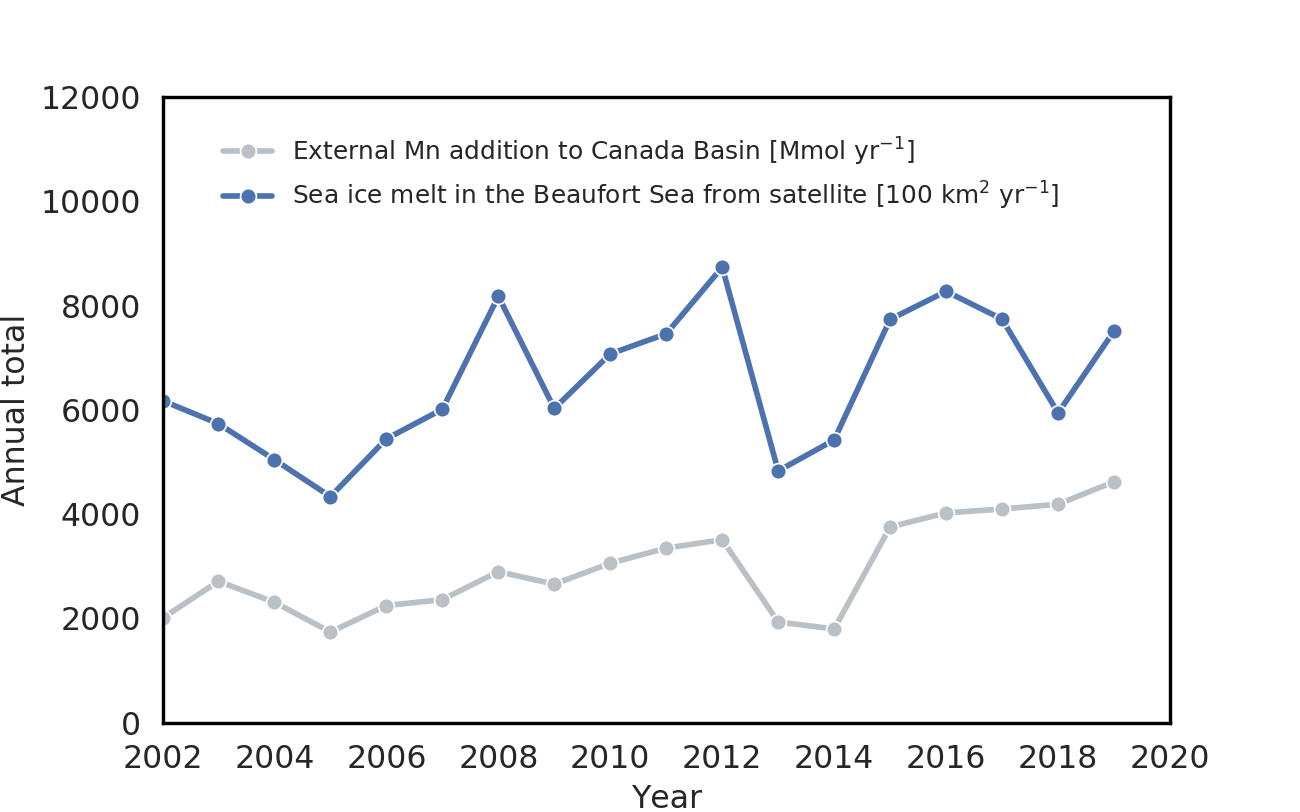

In [33]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("white")

with st:
#     sip = sns.lineplot(years, totals[:,2]*1e-6, linewidth=2.5, color=colors[5], marker="o", \
#                        markersize=7, label='Mn from sediment in sea ice [Mmol/yr]')    
#     osi = sns.lineplot(observ_years, yearly_melt*1e3, linewidth=2.5, marker='o', markersize=7, \
#                        label='Arctic sea ice extent reduction from satellite [1e3 Mkm2/yr]')
#     sip = sns.lineplot(years, totals_CB[:,2]*1e-6, linewidth=2.5, color=colors[5], marker="o", \
#                        markersize=7, label=r'Mn released from sea ice in Canada Basin [Mmol yr$^{-1}$]')
    sip = sns.lineplot(years, np.sum(totals_CB[:,:]*1e-6, axis=1), linewidth=2.5, color=colors[5], marker="o", \
                       markersize=7, label=r'External Mn addition to Canada Basin [Mmol yr$^{-1}$]')
    osi = sns.lineplot(observ_years_CB, yearly_melt_CB*1e-2, linewidth=2.5, marker='o', markersize=7, \
                       label=r'Sea ice melt in the Beaufort Sea from satellite [100 km$^{2}$ yr$^{-1}$]')

    sip.set_xlabel('Year', fontsize=14)
    sip.set_ylabel('Annual total',fontsize=14)
    sip.set(xlim=(2002, 2020), ylim=(0, 12000))
    sip.tick_params(axis='both', which='major', labelsize=14)
    sip.spines['left'].set_linewidth(1.5);   sip.spines['left'].set_color('black');
    sip.spines['bottom'].set_linewidth(1.5); sip.spines['bottom'].set_color('black');
    sip.spines['right'].set_linewidth(1.5);  sip.spines['right'].set_color('black');
    sip.spines['top'].set_linewidth(1.5);    sip.spines['top'].set_color('black');    
    
#     sip.ticklabel_format(style='scientific', axis='y')
#     osi.ticklabel_format(style='scientific', axis='y')
    
    sip.legend(loc=(0.05, 0.8), frameon=False)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/D1-annual-sea-ice-melt-'+ \
            str(date.today().strftime('%Y%m%d'))+'.png', bbox_inches='tight',dpi=300)

#### Canada Basin Mn content over time:

I'm curious whether a steady increase is visible. In that case it would be interesting to look at whether this is related to the increased freshwater storage of the Beaufort Gyre over the course of the 2000s.

In [26]:
def read_yearly_mn(years):
    
    yearly_mn = []
    for year in years:
        Mn_model1  = nc.Dataset(results_folder+'ref-'+str(year)+'/ANHA12_EXH006_'+str(year)+'_monthly.nc')
        Mn_dis1    = np.array(Mn_model1.variables['dissolmn'])[:,0,:,:,:]
        
        Mn_CB      = np.ma.masked_where(mask_CB_depth==0, Mn_dis1)
        
        # Polar mixed layer:
        Mn_yearly  = np.ma.sum(Mn_CB[:,0:17,:,:], axis=0)
        Mn_content = np.ma.sum(Mn_yearly*volume_masked[0:17,:,:]*1e3, axis=(0,1,2))
        yearly_mn.append(Mn_content) # moles
        
    return np.array(yearly_mn)

In [27]:
CB_mn_timeseries = read_yearly_mn(years)

<IPython.core.display.Javascript object>


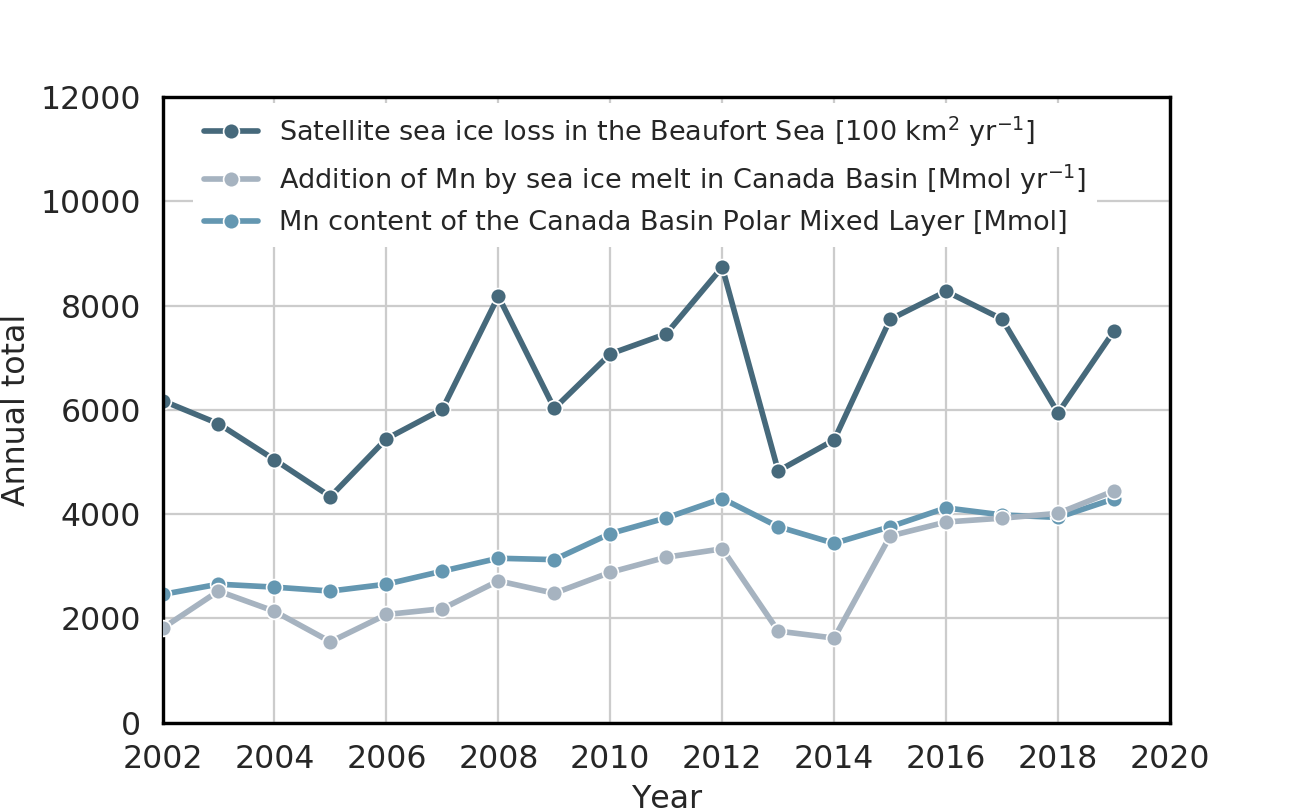

/home/brogalla/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/home/brogalla/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/home/brogalla/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/home/brogalla/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


In [80]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(observ_years_CB, yearly_melt_CB*1e-2, linewidth=2.5, marker='o', markersize=7, c='#46697b',\
                       label=r'Satellite sea ice loss in the Beaufort Sea [100 km$^{2}$ yr$^{-1}$]', zorder=1)
    sns.lineplot(years, totals_CB[:,2]*1e-6, linewidth=2.5, color='#a6b3c0', marker="o", \
                 markersize=7, label=r'Addition of Mn by sea ice melt in Canada Basin [Mmol yr$^{-1}$]', zorder=3)
    sns.lineplot(years, CB_mn_timeseries*1e-6, linewidth=2.5, marker='o', markersize=7, c='#6497b1', \
                 label=r'Mn content of the Canada Basin Polar Mixed Layer [Mmol]', zorder=2)
#     ax = sns.lineplot(years, np.sum(totals_CB[:,:]*1e-6, axis=1), linewidth=2.5, color=colors[5], marker="o", \
#                        markersize=7, label=r'External Mn addition to Canada Basin [Mmol yr$^{-1}$]')
    
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Annual total',fontsize=14)
    ax.set(xlim=(2002, 2020), ylim=(0, 1.2e4))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
#     ax.ticklabel_format(style='scientific', axis='y')
#     osi.ticklabel_format(style='scientific', axis='y')
    
    leg = ax.legend(loc=(0.03, 0.76), frameon=True, framealpha=1, fontsize=12)
    leg.get_frame().set_linewidth(0.0)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/D1-annual-sea-ice-melt-'+ \
            str(date.today().strftime('%Y%m%d'))+'.png', bbox_inches='tight',dpi=300)

Separated by region:

<IPython.core.display.Javascript object>


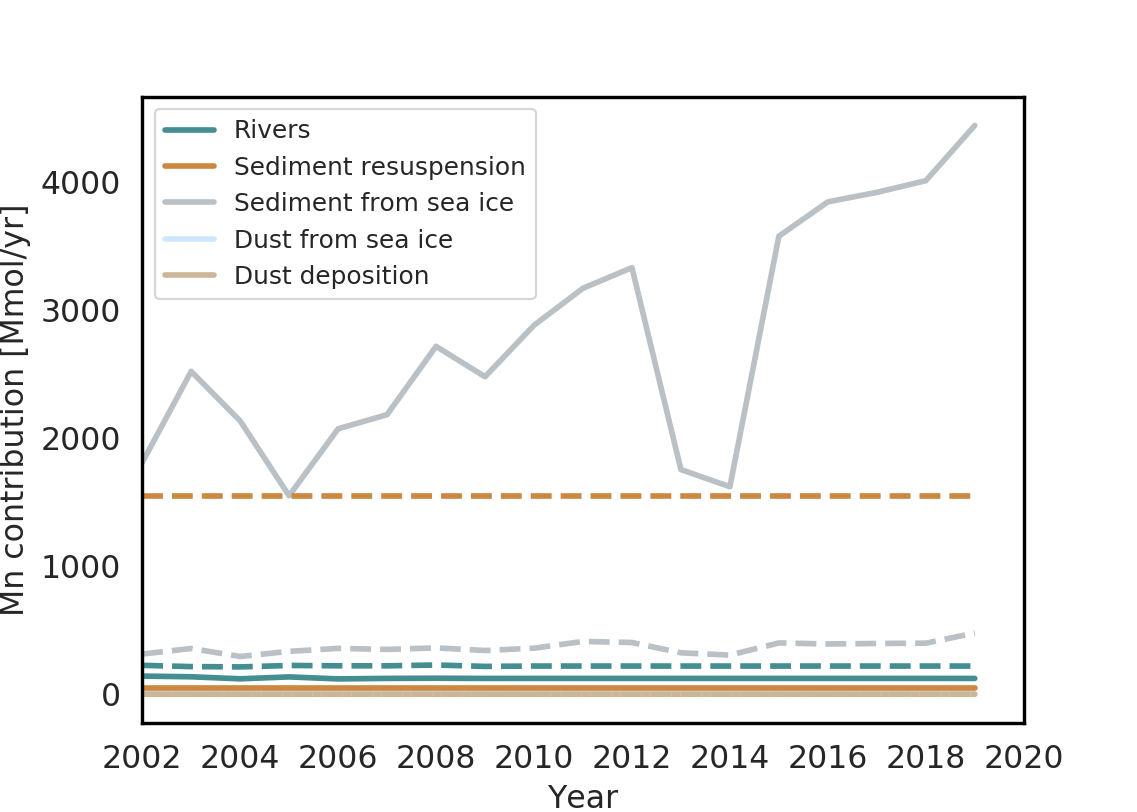

In [30]:
fig = plt.figure(figsize=(7,5))
st  = sns.axes_style("white")

with st:
    rp  = sns.lineplot(years, totals_CB[:,0]*1e-6, linewidth=2.5, color=colors[1], label='Rivers')
    sp  = sns.lineplot(years, totals_CB[:,1]*1e-6, linewidth=2.5, color=colors[3], label='Sediment resuspension')
    sip = sns.lineplot(years, totals_CB[:,2]*1e-6, linewidth=2.5, color=colors[5], label='Sediment from sea ice')
    dip = sns.lineplot(years, totals_CB[:,3]*1e-6, linewidth=2.5, color=colors[4], label='Dust from sea ice')
    dp  = sns.lineplot(years, totals_CB[:,4]*1e-6, linewidth=2.5, color=colors[0], label='Dust deposition')

    rp2  = sns.lineplot(years, totals_CAA[:,0]*1e-6, linewidth=2.5, color=colors[1])
    sp2  = sns.lineplot(years, totals_CAA[:,1]*1e-6, linewidth=2.5, color=colors[3])
    sip2 = sns.lineplot(years, totals_CAA[:,2]*1e-6, linewidth=2.5, color=colors[5])
    dip2 = sns.lineplot(years, totals_CAA[:,3]*1e-6, linewidth=2.5, color=colors[4])
    dp2  = sns.lineplot(years, totals_CAA[:,4]*1e-6, linewidth=2.5, color=colors[0])

    rp.lines[5].set_linestyle("--")
    rp.lines[6].set_linestyle("--")
    rp.lines[7].set_linestyle("--")
    rp.lines[8].set_linestyle("--")
    rp.lines[9].set_linestyle("--")
    
    rp.set_xlabel('Year', fontsize=14)
    rp.set_ylabel('Mn contribution [Mmol/yr]',fontsize=14)
    rp.set(xlim=(2002, 2020))
    rp.tick_params(axis='both', which='major', labelsize=14)
    rp.spines['left'].set_linewidth(1.5);   rp.spines['left'].set_color('black');
    rp.spines['bottom'].set_linewidth(1.5); rp.spines['bottom'].set_color('black');
    rp.spines['right'].set_linewidth(1.5);  rp.spines['right'].set_color('black');
    rp.spines['top'].set_linewidth(1.5);    rp.spines['top'].set_color('black');    
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-PML_src.png', bbox_inches='tight',dpi=300)